##  Pre-processing and Training Data Development

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Numeric data

In [2]:
diabetic_df = pd.read_csv('../data/diabetic_data_cleaned.csv',low_memory=False)

In [3]:
diabetic_df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,149190,55629189,Caucasian,Female,10-20,1,1,7,3,missing,...,No,Up,No,No,No,No,No,Ch,Yes,>30
1,64410,86047875,AfricanAmerican,Female,20-30,1,1,7,2,missing,...,No,No,No,No,No,No,No,No,Yes,NO
2,500364,82442376,Caucasian,Male,30-40,1,1,7,2,missing,...,No,Up,No,No,No,No,No,Ch,Yes,NO
3,16680,42519267,Caucasian,Male,40-50,1,1,7,1,missing,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,35754,82637451,Caucasian,Male,50-60,2,1,2,3,missing,...,No,Steady,No,No,No,No,No,No,Yes,>30


In [4]:
diabetic_df.select_dtypes([np.number]).columns

Index(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses'],
      dtype='object')

In [5]:
#evaluating skewness is with pandas’ “.skew” method
#It calculates the Fisher–Pearson standardized moment coefficient for all columns in a dataframe
num_feats = diabetic_df.dtypes[diabetic_df.dtypes != 'object'].index
skew_feats = diabetic_df[num_feats].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' : skew_feats})
skewness

,Skew
number_emergency,22.886190
number_outpatient,8.792090
number_inpatient,3.582834
discharge_disposition_id,2.747766
num_medications,1.343525
num_procedures,1.314532
admission_type_id,1.243556
time_in_hospital,1.127893
encounter_id,0.690222
patient_nbr,0.460250


#### 1. patient number
Remove patient_nbr - as it does not add any value to out model<br />

In [6]:
diabetic_df = diabetic_df.drop(['patient_nbr'], axis=1)

In [7]:
diabetic_df.shape

(98591, 47)

#### 2. encounter_id
A unique identifier for each admission<br />
Bin values for encounter id

In [8]:
#55000000
diabetic_df['binned_encounter_id'] = pd.cut(diabetic_df['encounter_id'], bins=[12500,110012500,220012500,330012500,443867222], labels=[1,2,3,4])

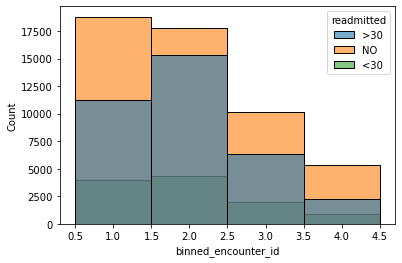

In [9]:
sns.histplot(x='binned_encounter_id', hue='readmitted', data=diabetic_df, alpha=0.6);

#### 3. time_in_hospital
Bin values for time in hospital

In [10]:
diabetic_df['binned_time_in_hospital'] = pd.cut(diabetic_df['time_in_hospital'], bins=[0,3,6,9,14], labels=['3_days','6_days','9_days','14_days'])

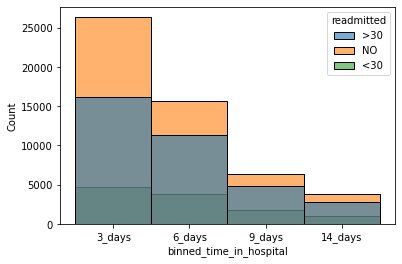

In [11]:
sns.histplot(x='binned_time_in_hospital', hue='readmitted', data=diabetic_df, alpha=0.6);

#### 4. admission_type_id
1-Emergency, 2-Urgent, 3-Elective, 4-Newborn, 5-Not Available, 7-Trauma center

In [12]:
print(diabetic_df['admission_type_id'].value_counts())

1    52125
3    18415
2    17949
5    10074
7       18
4       10
Name: admission_type_id, dtype: int64


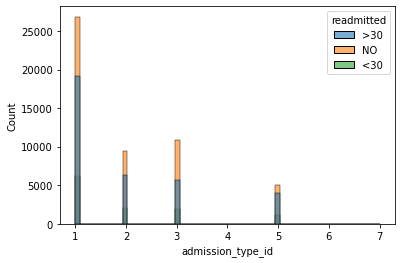

In [13]:
sns.histplot(x='admission_type_id', hue='readmitted', data=diabetic_df, alpha=0.6);

#### 5. discharge_disposition_id
Discharge Disposition refers where the patient was discharge to after treatment<br/>
 
patients expired where omitted from the dataset<br />
Patients transferred to another hospital for longer term care will not be counted as a readmission.<br/>
Exempt hospitals include psychiatric, rehabilitation, long term care, children’s, cancer, and critical access hospitals

In [14]:
# 13- Hospice/home, 14-Hospice/medical facilty
#10 - Neonate discharged to another hospital for neonatal aftercare
#28 - Discharged /transferred to a psychiatric hospital
#23 - Discharged/transferred to a long term care hospital
#22 - discharged /transferred to another rehab fac
#15 - Discharged/transferred to Medicare approved swing bed
index_names= diabetic_df.loc[diabetic_df['discharge_disposition_id'].isin([13,14,15,10,28,23,22])].index
diabetic_df.drop(index_names , inplace=True)

In [15]:
#1 Discharged to home
#6 Discharged /transferred to home with home health service (combined with #1)
#8 Discharged/transferred to home under care of Home IV provider (combined with #1)
diabetic_df['discharge_disposition_id'] = np.where(diabetic_df['discharge_disposition_id'] == 6, 1, diabetic_df['discharge_disposition_id'])
diabetic_df['discharge_disposition_id'] = np.where(diabetic_df['discharge_disposition_id'] == 8, 1, diabetic_df['discharge_disposition_id'])

#12 still patient or expected to return for outpatient services 
#16 Discharged or transferred to another hospital for outpatient services(combine with #12)
#17 Discharged or transferred to this hospital for outpatient services(combine with #12)
diabetic_df['discharge_disposition_id'] = np.where(diabetic_df['discharge_disposition_id'] == 16, 12, diabetic_df['discharge_disposition_id'])
diabetic_df['discharge_disposition_id'] = np.where(diabetic_df['discharge_disposition_id'] == 17, 12, diabetic_df['discharge_disposition_id'])

#5 Discharged/transferred to another type of inpatient care institution
#9 Admitted as an inpatient to this hospital
diabetic_df['discharge_disposition_id'] = np.where(diabetic_df['discharge_disposition_id'] == 5, 9, diabetic_df['discharge_disposition_id'])

In [16]:
diabetic_df['discharge_disposition_id'].value_counts()

1     71940
3     13897
25     4598
2      2115
9      1188
4       805
7       604
24       48
12       28
27        5
Name: discharge_disposition_id, dtype: int64

In [17]:
diabetic_df['discharge_disposition_id_log'] = np.log(diabetic_df['discharge_disposition_id'])

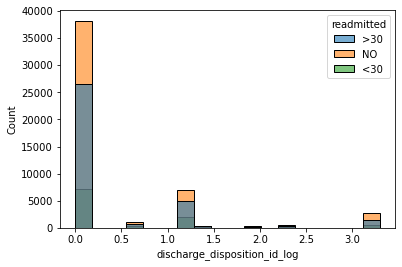

In [18]:
sns.histplot(x='discharge_disposition_id_log', hue='readmitted', data=diabetic_df, alpha=0.6);

#### 6. number_emergency
Number of Emergency visits by the patient in the year prior to the current encounter

In [19]:
diabetic_df['number_emergency_log'] = np.log(diabetic_df['number_emergency'] + 1)

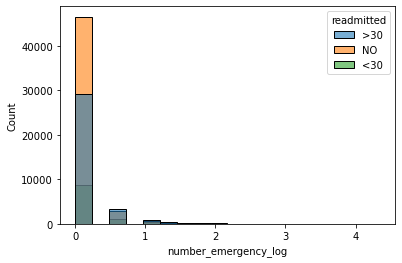

In [20]:
sns.histplot(x='number_emergency_log', hue='readmitted', data=diabetic_df, alpha=0.6);

#### 7.number_outpatient
Number of outpatient visits by the patient in the year prior to the current encounter

In [21]:
diabetic_df['number_outpatient_log'] = np.log(diabetic_df['number_outpatient']+1)

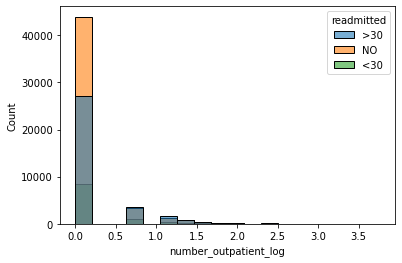

In [22]:
sns.histplot(x='number_outpatient_log', hue='readmitted', data=diabetic_df, alpha=0.6);

#### 8.number_inpatient
Number of inpatient visits by the patient in the year prior to the current encounter

In [23]:
diabetic_df['number_inpatient_log'] = np.log(diabetic_df['number_inpatient']+1)

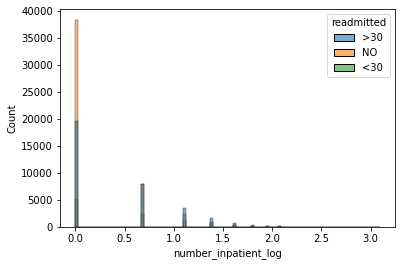

In [24]:
sns.histplot(x='number_inpatient_log', hue='readmitted', data=diabetic_df, alpha=0.6);

#### 9.num_medications
Number of medications administered during the encounter

In [25]:
diabetic_df['num_medications'].value_counts()

13    5801
12    5724
15    5538
11    5521
14    5426
      ... 
72       2
75       2
70       1
74       1
79       1
Name: num_medications, Length: 73, dtype: int64

#### 10. num_procedures
Number of procedures (other than lab tests) performed during the encounter

In [26]:
diabetic_df['num_procedures'].value_counts()

0    43794
1    19225
2    11821
3     8886
6     4678
4     3926
5     2898
Name: num_procedures, dtype: int64

#### 11.num_lab_procedures
Number of lab tests performed during the encounter

In [27]:
diabetic_df['num_lab_procedures'].value_counts()

1      3031
43     2648
44     2332
45     2237
38     2072
       ... 
114       1
118       1
129       1
120       1
121       1
Name: num_lab_procedures, Length: 118, dtype: int64

In [28]:
diabetic_df['num_lab_procedures'] = np.log(diabetic_df['num_lab_procedures'])

#### 12.admission_source_id
Decribes who or how the patient was referred to the hospital

In [29]:
diabetic_df['admission_source_id'].value_counts()

7     53738
1     27651
9      6676
4      3028
6      2099
2      1032
5       786
3       177
8        14
22       12
10        8
25        2
14        2
11        2
13        1
Name: admission_source_id, dtype: int64